In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib #matplolibで日本語を表示させるためのモジュール。インストールしていない場合は、!pip install japanize_matplotlib でインストールする・
from scipy.interpolate import interp1d

In [2]:
def polybas(kmin,kmax,Np,kgrid):
    """
    ----------------------------------------
    === 基底関数の行列を再帰的に求める関数 ===
    ----------------------------------------
    <input>
    ・kmin: 状態変数のグリッドの最小値
    ・kmax: 状態変数のグリッドの最大値
    ・Np: 多項式の次数-1   
    ・kgrid: 状態変数のグリッド(Ng個)
    <output>
    ・T: 基底関数の行列(NgxNp)
    (Ng個の評価点でNp-1次のチェビシェフ多項式で近似する)
    """
    Ng = len(kgrid) #グリッドの数
    x = (2/(kmax-kmin)) * (kgrid-kmin) - 1 #グリッドを[-1,1]の範囲に変換

    #基底関数の行列(NgxNp)を再帰的に求める
    T = np.zeros((Ng,Np))
    T0 = np.ones(Ng)
    T1 = x
    T2 = 2*x*T1 - T0
    T[:,0] = T1
    T[:,1] = T2

    for i in range(2,Np-1):
        T[:,i] = 2*x*T[:,i-1] - T[:,i-2]
    
    T = np.hstack([T0.reshape((Ng,1)),T[:,0:Np-1]])
    #np.linspaceで返されるベクトル(T0)は(Ng,)と1次元である。
    #このベクトルを行列に結合させるためにベクトルT0を(Ng,1)の2次元配列に変換している。 

    return T

In [3]:
def polygrid(kmin,kmax,N):
    """
    -----------------------------------------------
    === チェビシェフ多項式における評価点を返す関数 ===
    -----------------------------------------------
    <input>
    ・kmin: 状態変数のグリッドの最小値
    ・kmax: 状態変数のグリッドの最大値
    ・N: 状態変数のグリッド数
    <output>
    ・k: 状態変数のグリッド
    """
    #チェビシェフ極値点
    temp = np.linspace(0,N-1,N)
    x = -np.cos((np.pi/(N-1))*temp)

    #チェビシェフゼロ点
    #x = -np.cos((np.pi/2/(N-1))*(2*temp-1))
    #x[0] = 0.0

    #x([-1,1])からk([kmin,kmax])に変換
    k = 0.5*(kmax-kmin)*(x+1) + kmin

    return k

In [4]:
def f(x0):
    """
    ------------------
    === ルンゲ関数 ===
    ------------------
    """
    nx = x0.size
    f0 = np.ones(nx) / (np.ones(nx)+25*x0**2)

    return f0

### cheb_demo.m に対応

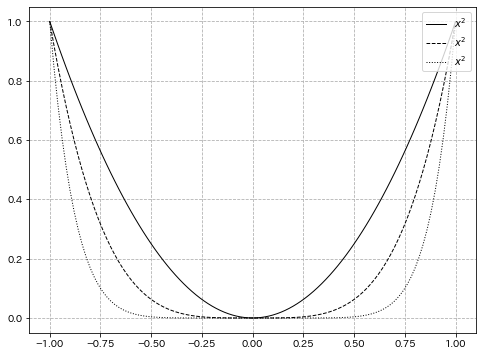

In [5]:
# ordinary polynomial
x = np.linspace(-1,1,101)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,x**2,c="k",lw=1,ls="-",label=r"$x^2$")
ax.plot(x,x**4,c="k",lw=1,ls="--",label=r"$x^2$")
ax.plot(x,x**8,c="k",lw=1,ls=":",label=r"$x^2$")
ax.legend(loc="upper right")
ax.grid(ls="--")
#fig.savefig("ordipoly.pdf")
plt.show()

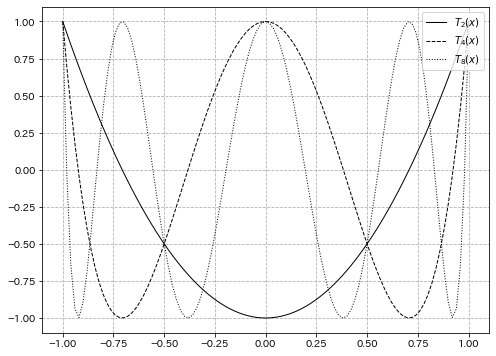

In [6]:
# Chebyshev polynomial
T = polybas(-1,1,9,x)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,T[:,2],c="k",ls="-",lw=1,label=r"$T_{2}(x)$")
ax.plot(x,T[:,4],c="k",ls="--",lw=1,label=r"$T_{4}(x)$")
ax.plot(x,T[:,8],c="k",ls=":",lw=1,label=r"$T_{8}(x)$")
ax.legend(loc="upper right")
ax.grid(ls="--")
#fig.savefig("chebpoly.pdf")
plt.show()

### how_to_interpolate_cheb.m に対応

In [7]:
#データ点
xmin = -1
xmax = 1
nxd = 11
xd = np.linspace(xmin,xmax,nxd)
yd = f(xd)

#関数による値
nx = 1001
x0 = np.linspace(xmin,xmax,nx)
y0 = f(x0)

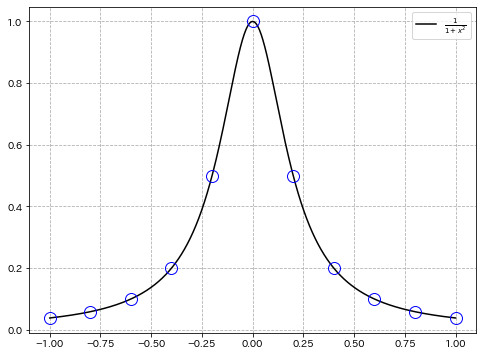

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x0,y0,c="k",lw=1.5,label=r"$\frac{1}{1+x^{2}}$")
ax.plot(xd, yd, "o", mfc="none", mec="b",markersize=12,lw=2)
ax.legend(loc="upper right")
ax.grid(ls="--")
#fig.savefig("Fig_data.pdf")
plt.show()

In [9]:
#Python関数(scipy.interpolate.interp1d)を使った線形補間による近似
x1 = np.linspace(xmin,xmax,nx)
#(xd,yd)による線形補間した関数を定義する
#Matlab関数(interp1)は補間と評価を1つの関数で行うが、interp1d関数では補間と評価を別々に行う。
interp_y1 = interp1d(xd,yd,kind="linear",fill_value="extrapolate") 
y1 = interp_y1(x1)

In [10]:
#通常の多項式による近似
Xd = np.ones((nxd,nxd))
X2 = np.ones((nx,nxd))
x2 = x1
for i in range(nxd-1):
    Xd[:,i+1] = xd**(i+1)
    X2[:,i+1] = x2**(i+1)

b = (np.linalg.inv(Xd.T @ Xd)) @ (Xd.T @ yd)
y2 = X2 @ b

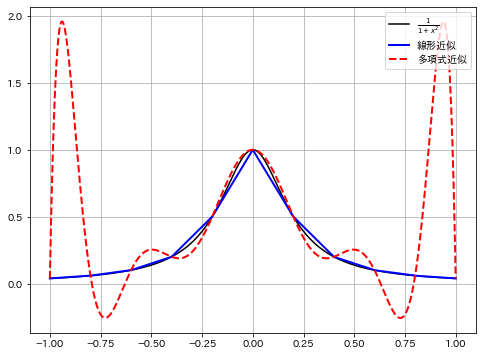

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x0,y0,c="k",ls="-",lw=1.5,label=r"$\frac{1}{1+x^{2}}$")
ax.plot(x1,y1,c="b",ls="-",lw=2.0,label="線形近似")
ax.plot(x2,y2,c="r",ls="--",lw=2.0,label="多項式近似")
ax.legend(loc="upper right")
ax.grid()
#fig.savefig("Fig_interp.pdf")
plt.show()

In [12]:
#チェビシェフ多項式による近似
nxd=11
xcheb = polygrid(xmin,xmax,nxd)
ycheb = f(xcheb)
T = polybas(xmin,xmax,nxd,xcheb)
theta = np.linalg.inv(T) @ ycheb

x3 = x1
T3 = polybas(xmin,xmax,nxd,x3)
y3 = T3@theta 

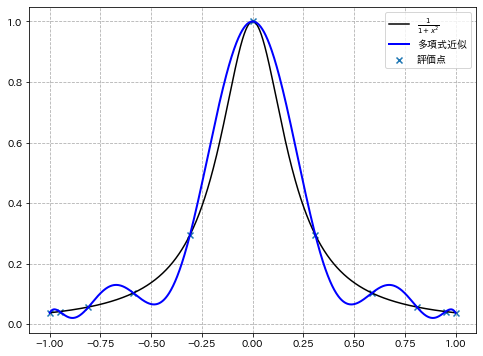

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x0,y0,c="k",ls="-",lw=1.5,label=r"$\frac{1}{1+x^{2}}$")
ax.plot(x3,y3,c="b",ls="-",lw=2.0,label="多項式近似")
ax.scatter(xcheb,ycheb,marker="x",label="評価点")
ax.legend(loc="upper right")
ax.grid(ls="--")
#fig.savefig("Fig_cheb_n11.pdf")
plt.show()

In [14]:
#チェビシェフ多項式による近似
nxd=21
xcheb = polygrid(xmin,xmax,nxd)
ycheb = f(xcheb)
T = polybas(xmin,xmax,nxd,xcheb)
theta = np.linalg.inv(T) @ ycheb

x3 = x1
T3 = polybas(xmin,xmax,nxd,x3)
y3 = T3 @ theta 

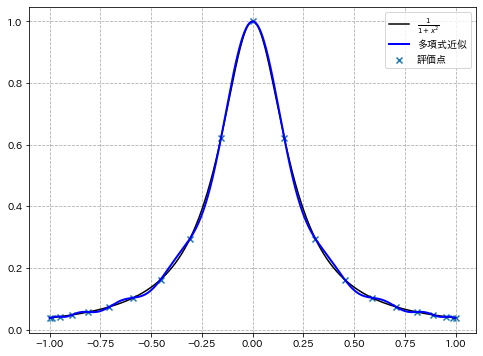

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x0,y0,c="k",ls="-",lw=1.5,label=r"$\frac{1}{1+x^{2}}$")
ax.plot(x3,y3,c="b",ls="-",lw=2.0,label="多項式近似")
ax.scatter(xcheb,ycheb,marker="x",label="評価点")
ax.legend(loc="upper right")
ax.grid(ls="--")
#fig.savefig("Fig_cheb_n21.pdf")
plt.show()